In [ ]:
### cell 1, Mount google Drive

from google.colab import drive
drive.mount('/content/drive')

In [30]:
### cell 2 , You have to cd TwinGAN Directory
!cd /content/drive/MyDrive/Colab/BeCat/twin_gan/TwinGAN

In [43]:
### cell 3 , insert your path of BeCat directory
PTH_PATH = '/content/drive/MyDrive/Colab/BeCat'

In [60]:
### cell 4
# make GanCat. This gancat will be created in ./content/demo_dir/demo_class
import os
try:
  os.mkdir('/content/demo_dir')
  os.mkdir('/content/demo_dir/demo_class')
except:
  print("Already directory exits")
!python inference/image_translation_infer.py

Already directory exits
Instructions for updating:
non-resource variables are not supported in the long term
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --model_path has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --output_tensor_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --output_image_path has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
Loading inference model
2021-12-16 14:27:30.404088: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.c

In [ ]:
### cell 5 
#Set Model

import os
import torch 
import torchvision
import torchvision.transforms as tr
from sklearn.metrics import classification_report, f1_score

# check cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('on cuda')
else:
    device = torch.device('cpu')
    print('on cpu')

#MODEL DEFINE

model = torchvision.models.resnet50(pretrained=True).to(device)

for parameter in model.parameters():
    parameter.requires_grad = False


class ModelFC(torch.nn.Module):
    def __init__(self,input_d,hidden_d,n_classes):
        super(ModelFC,self).__init__()
        self.fc1 = torch.nn.Linear(input_d,hidden_d)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_d,hidden_d//2)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_d//2,n_classes)
    
    def forward(self,x):
        x= self.fc1(x)
        x= self.relu1(x)
        x= self.fc2(x)
        x= self.relu2(x)
        x= self.fc3(x)
        return x

model.fc = ModelFC(2048,1024,12)
model.fc.to(device)

       

In [42]:
### cell 6
# define variables. If you want to train, you have to fix TRAIN,VALID,TEST_DATA_DIR PATH
# like '/to/fit/your/path/class_TTV/train'
# Global variables 

#PATH
TRAIN_DATA_DIR ='/content/drive/MyDrive/Colab/cat_breed_data/class_TTV/train'
VALID_DATA_DIR ='/content/drive/MyDrive/Colab/cat_breed_data/class_TTV/valid'
TEST_DATA_DIR ='/content/drive/MyDrive/Colab/cat_breed_data/class_TTV/test'
MODEL_SAVEPATH = '/content/checkpoints'
#Hyperparmeter
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EPOCHS = 10

In [9]:
### cell 7
# process DATA 


#preprocessing data
trans_train = tr.Compose([
    tr.Resize(256),
    tr.CenterCrop(224),
    tr.RandomPerspective(distortion_scale=0.1,p=0.2),
    tr.AutoAugment(),
    tr.ToTensor(),
    tr.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])


trans_valid = tr.Compose([
    tr.Resize(256),
    tr.CenterCrop(224),
    tr.ToTensor(),
    tr.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])

#load Data
trainData = torchvision.datasets.ImageFolder(TRAIN_DATA_DIR,transform = trans_train, is_valid_file = lambda x: x.endswith('.jpg'))
ValidData = torchvision.datasets.ImageFolder(VALID_DATA_DIR,transform = trans_valid, is_valid_file = lambda x: x.endswith('.jpg'))
testData = torchvision.datasets.ImageFolder(TEST_DATA_DIR,transform = trans_valid, is_valid_file = lambda x: x.endswith('.jpg'))


#set Data Loader
trainDataLoader = torch.utils.data.DataLoader(
    trainData,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 0
)
validDataLoader = torch.utils.data.DataLoader(
    ValidData,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 0
)
testDataLoader = torch.utils.data.DataLoader(
    testData,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 0
)



In [ ]:
### cell 8 

# Train #

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

def train(model,epochs, critertion,optimzer,trainDataLoader,validDataLoader,device,model_savepath,logging_interval: int = 50):
    best_valid_f1 = 0.0
    os.makedirs(model_savepath,exist_ok=True)

    for epoch in range(epochs):
        model.train()
        for batch_idx,(batch_data,batch_labels) in enumerate(trainDataLoader):
            inputs = batch_data.to(device)
            y_true = batch_labels.to(device)
            optimizer.zero_grad()

            y_pred = model(inputs)
            loss = criterion(y_pred,y_true)
            loss.backward()
            optimizer.step()

            if(batch_idx + 1) % logging_interval == 0:
                print('Epoch: {}\t| Batch: {}\t| Loss: {}'.format(epoch+1,batch_idx+1,loss))
        model.eval()
        y_true = []
        y_pred = []
        for valid_data, valid_labels in validDataLoader:
            valid_data = valid_data.to(device)
            valid_labels = valid_labels.to(device)

            with torch.no_grad():
                valid_preds = model(valid_data)
            valid_pred_labels = torch.argmax(valid_preds, dim=1)
            y_true.extend(valid_labels.detach().cpu().numpy())
            y_pred.extend(valid_pred_labels.detach().cpu().numpy())    
        valid_f1 = f1_score(y_true,y_pred,average='macro')
        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            torch.save(model.state_dict(),os.path.join(model_savepath,'best_checkpoint.pth'))
        print('Epoch {} F1-score: {}\t| Best F1-score: {}'.format(epoch+1,valid_f1,best_valid_f1))
        torch.save(model.state_dict(),os.path.join(model_savepath,'epoch_{}_checkpoint.pth'.format(epoch+1)))
    


        
#Start Train
train(model,EPOCHS,criterion,optimizer,trainDataLoader,validDataLoader,device,MODEL_SAVEPATH)


In [37]:
# cell 9 
###Test###

model.load_state_dict(torch.load(os.path.join(MODEL_SAVEPATH,'best_checkpoint.pth')))
model.eval()

y_true = []
y_pred = []

for testData , test_labels in testDataLoader:
    testData = testData.to(device)
    test_labels = test_labels.to(device)
    with torch.no_grad():
        test_preds = model(testData)
    test_pred_labels = torch.argmax(test_preds,dim=1)
    y_true.extend(test_labels.detach().cpu().numpy())
    y_pred.extend(test_pred_labels.detach().cpu().numpy())

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        19
           1       0.93      0.68      0.79        19
           2       0.90      0.95      0.92        19
           3       1.00      1.00      1.00        18
           4       0.90      0.95      0.93        20
           5       0.86      0.90      0.88        20
           6       0.94      0.80      0.86        20
           7       0.87      1.00      0.93        20
           8       0.88      0.75      0.81        20
           9       0.84      0.80      0.82        20
          10       1.00      0.95      0.97        20
          11       1.00      1.00      1.00        20

    accuracy                           0.89       235
   macro avg       0.90      0.89      0.89       235
weighted avg       0.90      0.89      0.89       235



If you were a cat, you'd probably be...... Bombay!!


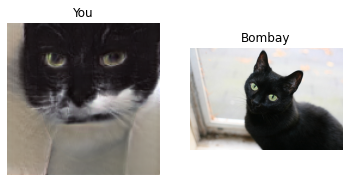

In [61]:
# cell 10 
# Run on Demo files. 
# If you want to run this cell without train, it must exits twinGan weight file in TwinGAN dir. 
#like '/content/drive/MyDrive/Colab/BeCat/twin_gan/TwinGAN/128'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


#load Data
DEMO_DATA_DIR = '/content/demo_dir'

#%cd '{./demo_dir}'
#!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +

demoData = torchvision.datasets.ImageFolder(DEMO_DATA_DIR,transform = trans_valid, is_valid_file = lambda x: x.endswith('.png'))
demoDataLoader = torch.utils.data.DataLoader(
    demoData,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 0
)

# model run
try:
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVEPATH,'best_checkpoint.pth')))
except:
  model.load_state_dict(torch.load(os.path.join(PTH_PATH,'best_checkpoint.pth')))

model.eval()

for demoData , demo_labels in demoDataLoader:
    demoData = demoData.to(device)
    demo_labels = demo_labels.to(device)
    with torch.no_grad():
        demo_preds = model(demoData)
    demo_pred_labels = torch.argmax(demo_preds,dim=1)

label=['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau',
       'Maine_Coon','Persian','Ragdoll','Russian_Blue','Siamese','Sphynx']
pred_lab=demo_pred_labels.item()


pred_cat_breed=label[pred_lab]


# Print Result

print("If you were a cat, you'd probably be...... {}!!".format(pred_cat_breed))

fig = plt.figure()
rows = 1
cols = 2

SAMPLE_PATH = os.path.join(PTH_PATH,"compare_sample")
img1 = cv2.imread('/content/demo_dir/demo_class/demo.png')
img2 = cv2.imread(os.path.join(SAMPLE_PATH,'{}.jpg'.format(pred_cat_breed)))
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
ax1.set_title('You')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title(pred_cat_breed)
ax2.axis("off")

plt.show()
